# Clasificación de imagenes satelitales mediante algoritmos de Machine Learning - Random Forest
## Sector Embalse Neusa 
### Dirección de Laboratorio e Innovación Ambiental DLIA
#### Modelos Digitales Ambientales

@ Ing. Nicolas Viasus Valero

@ Msc. Julian Segura

Version: 0.1

Fecha: 2023-10-24

Clasificación de imagenes satelitales a partir de datos de entrenamiento por el algoritmo de machine learning Random Forest



Este script esta basado en el codigo realizado por *[Crhis Holden](http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)* y adaptado por *[Florian Beyer](https://github.com/florianbeyer/RandomForest-Classification/blob/master/Classification_script.ipynb)*


----


## Sección - Librerias y datos de ingreso

- datos de ingreso para realizar el algoritmo Random Forest a partir de datos de entrenamiento y prueba sobre imagenes satelitales 

In [48]:
# packages
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
from sklearn.ensemble import RandomForestClassifier # classifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix  # calculating measures for accuracy assessment
import seaborn as sn
import datetime

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [49]:
# define a number of trees that should be used (default = 500)
est = 500

# how many cores should be used?
# -1 -> all available cores
n_cores = -1


# the remote sensing image you want to classify
img_RS = r"E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF_V2\Neusa.tif"

# training and validation folder files 
path=r"E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF_V2"

# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'class'

# directory, where the classification image should be saved:
classification_image = path+"\\classifd.tif"

# directory, where the all meta results should be saved:
results_txt = path+"\\results.txt"

***
## Sección - Preprocesamiento de datos 

### Segmentación datos de entrenamiento en *trainging data* (Entrenamiento) y *Testing data* (datos de comprobación) 

In [50]:
# split the truth data into training and test data sets and save each to a new shapefile
# Read shapefile
gdf=gpd.read_file(path+"\\Entrenamiento\\Entrenamiento.shp")

gdf_train = gdf.sample(frac=0.7)
gdf_test = gdf.drop(gdf_train.index)
print('Datos de entrenamiento', gdf.shape, 'training data:', gdf_train.shape, 'testing data:', gdf_test.shape)
gdf_train.to_file(path+"\\Entrenamiento\\train.shp")
gdf_test.to_file(path+"\\Entrenamiento\\test.shp")

#Set variables Traingin and test data
training = path+"\\Entrenamiento\\train.shp"
validation = path+"\\Entrenamiento\\test.shp"


Datos de entrenamiento (31, 2) training data: (22, 2) testing data: (9, 2)


In [51]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Atributos disponibles en datos de entrenamiento: {}'.format(attributes))

Atributos disponibles en datos de entrenamiento: ['Class']


In [52]:
# prepare results text file:

print('Random Forest Classification', file=open(results_txt, "a"))
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))
print('PATHS:', file=open(results_txt, "a"))
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
print('Training shape: {}'.format(training) , file=open(results_txt, "a"))
print('Vaildation shape: {}'.format(validation) , file=open(results_txt, "a"))
print('      choosen attribute: {}'.format(attribute) , file=open(results_txt, "a"))
print('Classification image: {}'.format(classification_image) , file=open(results_txt, "a"))
print('Report text file: {}'.format(results_txt) , file=open(results_txt, "a"))
print('-------------------------------------------------', file=open(results_txt, "a"))



In [53]:
# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()



In [54]:
row = img_ds.RasterYSize
col = img_ds.RasterXSize
band_number = img_ds.RasterCount

print('Extensión de la imagen : {} x {} (row x col)'.format(row, col))
print('Numbero de Bandas: {}'.format(band_number))


print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
print('Numero de Bandas: {}'.format(band_number), file=open(results_txt, "a"))
print('---------------------------------------', file=open(results_txt, "a"))
print('TRAINING', file=open(results_txt, "a"))
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))

Extensión de la imagen : 5276 x 5339 (row x col)
Numbero de Bandas: 8


In [55]:
# laod training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(training)
shape_layer = shape_dataset.GetLayer()

mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()

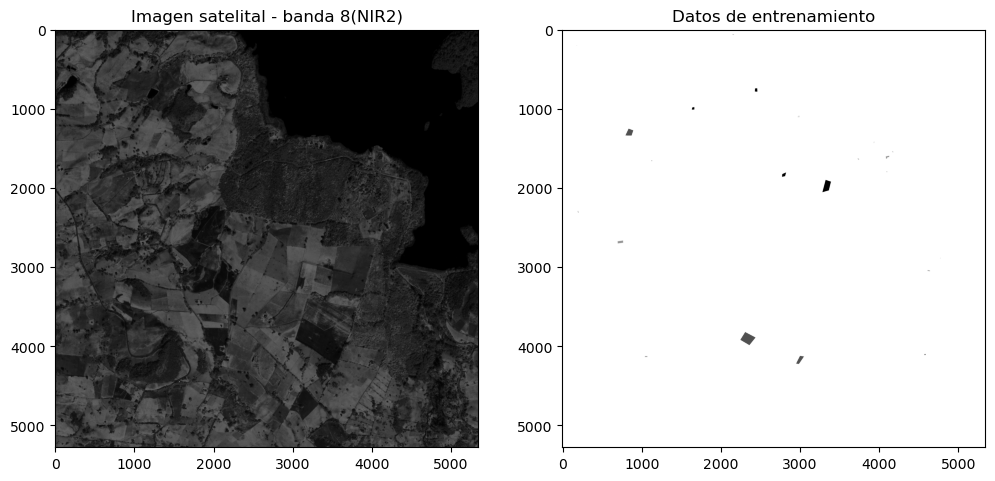

48274 muuestras de entrenamiento
Los datos de entrenamiento incluyen 4 clases: [1 2 3 4]
Tamaño de la matriz X : (48274, 8)
Tamaño de la matriz Y: (48274,)


In [56]:
# Display images
plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(img[:, :, 7], cmap=plt.cm.Greys_r)
plt.title('Imagen satelital - banda 8(NIR2)')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Greys)
plt.title('Datos de entrenamiento')

plt.show()

# Number of training pixels:
n_samples = (roi > 0).sum()
print('{n} muuestras de entrenamiento'.format(n=n_samples))
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('Los datos de entrenamiento incluyen {n} clases: {classes}'.format(n=labels.size, classes=labels))
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))

# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

print('Tamaño de la matriz X : {sz}'.format(sz=X.shape))
print('Tamaño de la matriz Y: {sz}'.format(sz=y.shape))

*** 
## Sección - Entrenamiento del algoritmo *Random Forest*

In [57]:
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)

# verbose = 2 -> prints out every tree progression
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)



X = np.nan_to_num(X)
rf2 = rf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.3s finished


### Diagnostico del entrenamiento del algoritmo *Random Forest*

In [58]:
# With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

print('--------------------------------', file=open(results_txt, "a"))
print('TRAINING and RF Model Diagnostics:', file=open(results_txt, "a"))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
print('OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))


# we can show the band importance:
bands = range(1,img_ds.RasterCount+1)

for b, imp in zip(bands, rf2.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))
    print('Band {b} importance: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))

    
# Let's look at a crosstabulation to see the class confusion. 
# To do so, we will import the Pandas library for some help:
# Setup a dataframe -- just like R
# Exception Handling because of possible Memory Error

try:
    df = pd.DataFrame()
    df['truth'] = y
    df['predict'] = rf.predict(X)

except MemoryError:
    print('Crosstab not available ')

else:
    # Cross-tabulate predictions
    print(pd.crosstab(df['truth'], df['predict'], margins=True))
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))

OOB prediction of accuracy is: 99.70377428843685%
Band 1 importance: 0.06319217104647253
Band 2 importance: 0.07916007263248268
Band 3 importance: 0.15541453172294914
Band 4 importance: 0.12167389376842756
Band 5 importance: 0.10221984162784735
Band 6 importance: 0.0979332468484015
Band 7 importance: 0.1840720010331516
Band 8 importance: 0.19633424132026764


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s


predict    1     2      3      4    All
truth                                  
1        741     0      0      0    741
2          0  4885      0      0   4885
3          0     0  27937      0  27937
4          0     0      0  14711  14711
All      741  4885  27937  14711  48274


[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.6s finished


### Matriz de confusión entrenamiento del algoritmo

Matriz de confusión sobre el entrenamiento del algoritmo *Random Forest*

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    0.5s finished


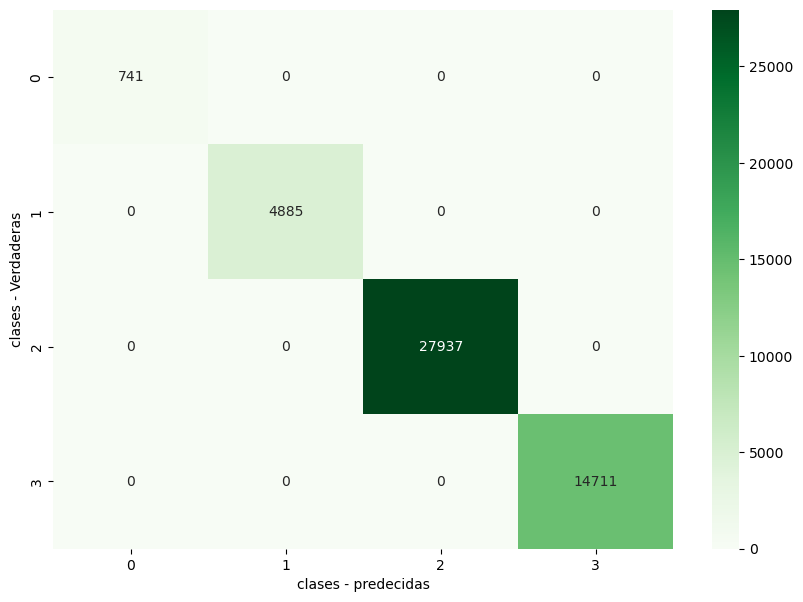

In [59]:
cm = confusion_matrix(y,rf.predict(X))
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='g',cmap='Greens')
plt.xlabel('clases - predecidas')
plt.ylabel('clases - Verdaderas')
plt.show()

***
## Sección - Predicción de la imagen satelital

In [60]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (5276, 5339, 8) to (28168564, 8)


c:\Users\NicolasViasus\.conda\envs\mda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [61]:
# Now predict for each pixel
# first prediction will be tried on the entire image
# if not enough RAM, the dataset will be sliced
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array)/1000))

    test = True
    
    while test == True:
        try:
            class_preds = list()
            
            temp = rf.predict(img_as_array[0:slices+1,:])
            class_preds.append(temp)
            
            for i in range(slices,len(img_as_array),slices):
                print('{} %, derzeit: {}'.format((i*100)/(len(img_as_array)), i))
                temp = rf.predict(img_as_array[i+1:i+(slices+1),:])                
                class_preds.append(temp)
            
        except MemoryError as error:
            slices = slices/2
            print('Not enought RAM, new slices = {}'.format(slices))
            
        else:
            test = False
else:
    print('Class prediction was successful without slicing!')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   30.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  5.6min finished


Class prediction was successful without slicing!


In [62]:
# concatenate all slices and re-shape it to the original extend
try:
    class_prediction = np.concatenate(class_preds,axis = 0)
except NameError:
    print('No slicing was necessary!')
    
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(class_prediction.shape))

No slicing was necessary!
Reshaped back to (5276, 5339)


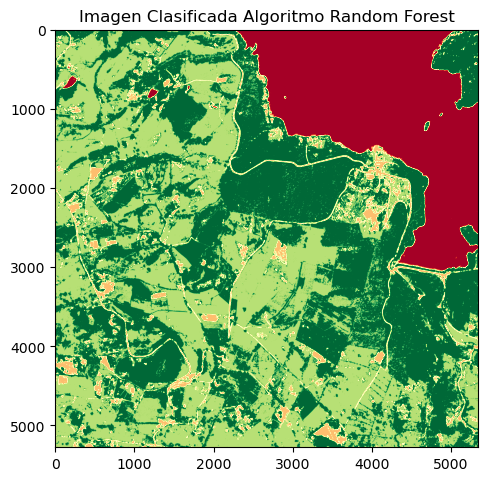

In [91]:
#Plot image classification
class_prediction.astype(np.float16)
plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(class_prediction, cmap=plt.cm.RdYlGn)
plt.title('Imagen Clasificada Algoritmo Random Forest')

plt.show()

### Almacenamiento de la imagen clasificada en disco local

In [65]:
cols = img.shape[1]
rows = img.shape[0]

class_prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(class_prediction)
outdata.FlushCache() ##saves to disk!!
print('Imagen guardada en: {}'.format(classification_image))

Imagen guardada en: E:\TOPOGRAFIA\MDA\Proyecto Retamo\Codigo_RF_V2\classifd.tif


***
## Sección - Validación y precisión del algoritmo para la imagen clasificada

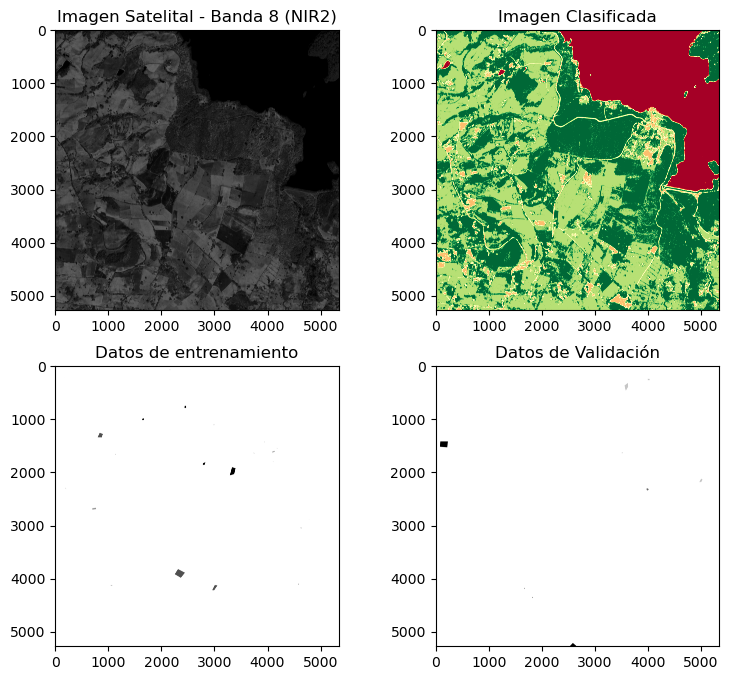

30017 Pixeles de validación (Testing data)
Datos de validación incluye 3 clases: [1 2 3]
Tamaño de la matriz X: (30017,)
Tanaño de la matriz Y: (30017,)
col_0     1     2      3    4    All
row_0                               
1      8984     0      0    0   8984
2         0  2033      0    0   2033
3         0     3  18654  343  19000
All    8984  2036  18654  343  30017
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8984
           2       1.00      1.00      1.00      2033
           3       1.00      0.98      0.99     19000
           4       0.00      0.00      0.00         0

    accuracy                           0.99     30017
   macro avg       0.75      0.75      0.75     30017
weighted avg       1.00      0.99      0.99     30017

OAA = 98.84731985208381 %


c:\Users\NicolasViasus\.conda\envs\mda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NicolasViasus\.conda\envs\mda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NicolasViasus\.conda\envs\mda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# validation / accuracy assessment

# preparing ttxt file

print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# laod training data from shape file
shape_dataset_v = ogr.Open(validation)
shape_layer_v = shape_dataset_v.GetLayer()
mem_drv_v = gdal.GetDriverByName('MEM')
mem_raster_v = mem_drv_v.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())
mem_band_v = mem_raster_v.GetRasterBand(1)
mem_band_v.Fill(0)
mem_band_v.SetNoDataValue(0)

# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None

roi_v = mem_raster_v.ReadAsArray()



# vizualise
plt.figure(figsize=(9,8))
plt.subplot(221)
plt.imshow(img[:, :, 7], cmap=plt.cm.Greys_r)
plt.title('Imagen Satelital - Banda 8 (NIR2)')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.RdYlGn)
plt.title('Imagen Clasificada')


plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Greys)
plt.title('Datos de entrenamiento')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Greys)
plt.title('Datos de Validación')

plt.show()


# Find how many non-zero entries we have -- i.e. how many validation data samples?
n_val = (roi_v > 0).sum()
print('{n} Pixeles de validación (Testing data)'.format(n=n_val))
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

# What are our validation labels?
labels_v = np.unique(roi_v[roi_v > 0])
print('Datos de validación incluyen {n} clases: {classes}'.format(n=labels_v.size, classes=labels_v))
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))
# Subset the classification image with the validation image = X
# Mask the classes on the validation dataset = y
# These will have n_samples rows
X_v = class_prediction[roi_v > 0]
y_v = roi_v[roi_v > 0]

print('Tamaño de la matriz X: {sz_v}'.format(sz_v=X_v.shape))
print('Tanaño de la matriz Y: {sz_v}'.format(sz_v=y_v.shape))

# Cross-tabulate predictions
# confusion matrix
convolution_mat = pd.crosstab(y_v, X_v, margins=True)
print(convolution_mat)
print(convolution_mat, file=open(results_txt, "a"))
# if you want to save the confusion matrix as a CSV file:
#savename = 'C:\\save\\to\\folder\\conf_matrix_' + str(est) + '.csv'
#convolution_mat.to_csv(savename, sep=';', decimal = '.')

# information about precision, recall, f1_score, and support:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#sklearn.metrics.precision_recall_fscore_support
target_names = list()
for name in range(1,(labels.size)+1):
    target_names.append(str(name))
sum_mat = classification_report(y_v,X_v,target_names=target_names)
print(sum_mat)
print(sum_mat, file=open(results_txt, "a"))

# Overall Accuracy (OAA)
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100))
print('OAA = {} %'.format(accuracy_score(y_v,X_v)*100), file=open(results_txt, "a"))

### Matriz de confusión

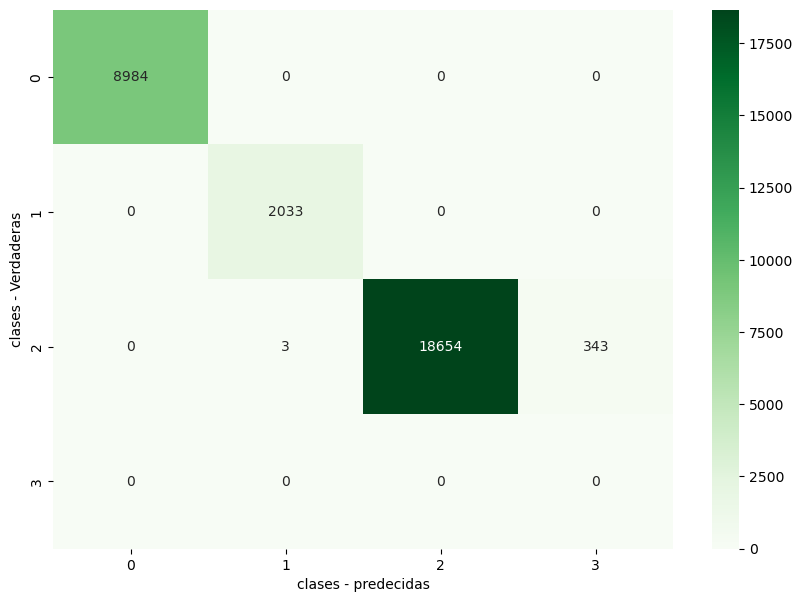

In [92]:
cm_val = confusion_matrix(roi_v[roi_v > 0],class_prediction[roi_v > 0])
plt.figure(figsize=(10,7))
sn.heatmap(cm_val, annot=True, fmt='g',cmap='Greens')
plt.xlabel('clases - predecidas')
plt.ylabel('clases - Verdaderas')
plt.show()